In [1]:
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Lipinski
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors, rdFMCS, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

from tqdm import tqdm
from rdkit.ML.Cluster.Butina import ClusterData
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.SimDivFilters.rdSimDivPickers import HierarchicalClusterPicker, ClusterMethod

from IPython.core.display import display, HTML, Math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import mols2grid

import time
rdDepictor.SetPreferCoordGen(True)

%pylab inline
print(rdkit.__version__)

cmap = plt.get_cmap("tab10")


Populating the interactive namespace from numpy and matplotlib
2020.09.1


Mapping between Alpha's Enamine IDs and my previously selected molecules

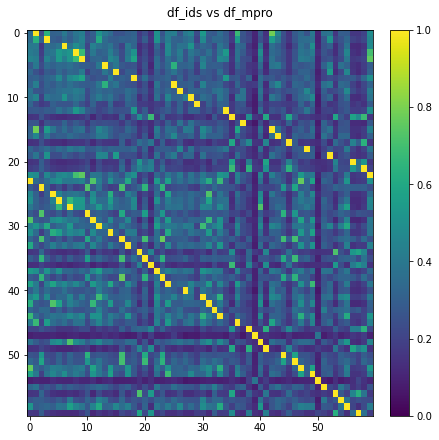

,smiles,membership,fps,enamine,nonchiral
2,[H]OC[C@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])C...,64,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F
10,[H]OC[C@H](CN([H])C(=O)Cc1cc(F)ccc1F)N([H])Cc1...,42,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,O=C(Cc1cc(F)ccc1F)NCC(CO)NCc1ccns1
16,[H]OC[C@H](CN([H])C(=O)c1cccnc1C)N([H])Cc1cc(F...,36,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1ncccc1C(=O)NCC(CO)NCc1cc(F)ccc1F
19,[H]N([H])C(=O)c1ccc(C(=O)N([H])C[C@@H]2CCN2C(=...,33,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NC(=O)c1ccc(C(=O)NCC2CCN2C(=O)c2ccns2)[nH]1
20,[H]OC[C@H](CN([H])C(=O)c1cc(C)sn1)N([H])Cc1ccc...,32,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1cc(C(=O)NCC(CO)NCc2ccc(F)c(F)c2)ns1
21,[H]N([H])C(=O)c1cc(C(=O)N(C)[C@@H]2CCN(C(=O)c3...,31,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,CN(C(=O)c1c[nH]c(C(N)=O)c1)C1CCN(C(=O)c2cocn2)C1
22,[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1ccc(Cl)c(S...,30,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,NS(=O)(=O)c1cc(C(=O)NC(CO)c2ccc(F)cc2)ccc1Cl
23,[H]OC[C@@H](CN([H])C(=O)c1c(F)ccc(C)c1F)N([H])...,30,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1ccc(F)c(C(=O)NCC(CO)NCc2nccs2)c1F
30,[H]O[C@H](CN([H])S(=O)(=O)c1cccc(C(=O)N([H])[H...,28,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,NC(=O)c1cccc(S(=O)(=O)NCC(O)c2c(F)cccc2Cl)c1
41,[H]N([H])C(=O)c1ccc(C(=O)N(C)C[C@H](C)N([H])C(...,26,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,CC(CN(C)C(=O)c1ccc(C(N)=O)[nH]1)NC(=O)c1ccsn1


In [2]:
df_ids = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/mpro_mols.csv')

df_mpro = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained.csv')

df_ids['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_ids["smiles"]]  # pharmacophore fingerprint
df_mpro['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_mpro["smiles"]]  # pharmacophore fingerprint

sim_mat = np.empty((len(df_ids), len(df_mpro)))
for i in range(len(df_ids)):
    sim_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(df_ids['fps'].values[i], df_mpro['fps'].values))

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('df_ids vs df_mpro')
cax = ax.matshow(sim_mat, aspect="auto", vmin=0, vmax=1)
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)
plt.show()

for ind in range(len(df_mpro)):
    assert sim_mat[ind, np.argmax(sim_mat[ind])] == 1.0
    df_mpro.at[np.argmax(sim_mat[ind]),
               'enamine'] = df_ids.iloc[ind]['enamine']
    df_mpro.at[np.argmax(sim_mat[ind]),
               'nonchiral'] = df_ids.iloc[ind]['smiles']

display(df_mpro[df_mpro['enamine'].isnull()])
df_mpro['mol'] = df_mpro['smiles'].apply(Chem.MolFromSmiles)

pick_grid = mols2grid.display(df_mpro, template="pages", smiles_col='smiles', mol_col='mol',
                              n_rows=15, n_cols=4, subset=["img", "membership"], transform={"membership": lambda x: f"membership: {x}"},
                              tooltip=['smiles'],
                              maxMols=60, size=(300, 150))

display(pick_grid)


# Visualise all clustered molecules & picks

Recalculating centroids because RDKit is silly

In [3]:
def gen_dmat(fps):
    dmat = np.empty((len(fps), len(fps)))
    for i in range(len(fps)):
        dmat[i] = np.ones_like(
            len(fps)) - np.array(DataStructs.BulkTanimotoSimilarity(fps[i], fps))
    return dmat

df_clustered = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_clustered.csv')
df_clustered['mol'] = df_clustered['nonchiral'].apply(Chem.MolFromSmiles)
df_clustered['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in tqdm(df_clustered["smiles"])]  # pharmacophore fingerprint

clusters = df_clustered.groupby('cluster')
cluster_inds = [list(cluster) for cluster in clusters]

centroid_smiles = []
membership_list = []
for cluster, df_tmp in tqdm(clusters):
    df_tmp = df_tmp.reset_index()
    membership_list.append(len(df_tmp))
    dmat = gen_dmat(df_tmp['fps'].values)
    centroid_ind = np.argmin(np.amax(dmat, axis=1))
    centroid_smiles.append(df_tmp.iloc[centroid_ind]['smiles'])

centroid_df = df_clustered[df_clustered['smiles'].isin(centroid_smiles)]
# sort values based on centroid_smiles
centroid_df['sort_cat'] = pd.Categorical(
    centroid_df['smiles'], categories=centroid_smiles, ordered=True)
centroid_df.sort_values('sort_cat', inplace=True)
centroid_df.reset_index(inplace=True)
centroid_df['membership'] = membership_list
display(centroid_df[['smiles', 'nonchiral', 'cluster', 'membership']])


100%|██████████| 24748/24748 [00:16<00:00, 1517.12it/s]
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,smiles,nonchiral,cluster,membership
0,[H]OC[C@H](c1cc(F)ccc1F)N([H])C(=O)N([H])c1ccc...,NC(=O)c1cccc(NC(=O)NC(CO)c2cc(F)ccc2F)c1,0,100
1,[H]N([H])S(=O)(=O)c1ccc(F)c(CN([H])S(=O)(=O)c2...,NS(=O)(=O)c1ccc(F)c(CNS(=O)(=O)c2ccccc2F)c1,1,81
2,[H]OC[C@@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])...,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F,2,64
3,[H]N(Cc1ccc(F)c(F)c1)C(=O)c1cc(S(=O)(=O)N([H])...,NS(=O)(=O)c1ccc(Cl)c(C(=O)NCc2ccc(F)c(F)c2)c1,3,52
4,[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)N([...,COc1ccc(F)cc1NC(=O)NC(C(N)=O)c1ccc(F)cc1,4,52
...,...,...,...,...
24743,[H]OC1=NC(=O)N(CC(=O)N(C)[C@@H](C)CN([H])C(=O)...,COC(=O)NCC(=O)NCC(C)N(C)C(=O)CN1CC(O)=NC1=O,24743,1
24744,[H]N(Cc1ccn2ccnc2c1)C(=O)N([H])c1cc(F)cc(S(=O)...,NS(=O)(=O)c1cc(F)cc(NC(=O)NCc2ccn3ccnc3c2)c1,24744,1
24745,[H]N(Cc1cccc2c1ccn2[H])C(=O)N([H])c1cc(F)cc(S(...,NS(=O)(=O)c1cc(F)cc(NC(=O)NCc2cccc3[nH]ccc23)c1,24745,1
24746,[H]N(CC(C)(C)N1CCN(C)CC1)C(=S)N([H])C1CCN(C)CC1,CN1CCC(NC(=S)NCC(C)(C)N2CCN(C)CC2)CC1,24746,1


Difference between previously selected molecules and new centroids

In [4]:
df_picks = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained_new.csv')
centroid_picks = centroid_df.iloc[:80]
pd.set_option('max_colwidth', -1)
display(centroid_picks[~centroid_picks['smiles'].isin(
    df_picks['smiles'])][['smiles']])


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,smiles
0,[H]OC[C@H](c1cc(F)ccc1F)N([H])C(=O)N([H])c1cccc(C(=O)N([H])[H])c1
1,[H]N([H])S(=O)(=O)c1ccc(F)c(CN([H])S(=O)(=O)c2ccccc2F)c1
2,[H]OC[C@@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])Cc1cncs1
3,[H]N(Cc1ccc(F)c(F)c1)C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1Cl
4,[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)N([H])c1cc(F)ccc1OC
...,...
75,[H]O[C@@H](CN([H])S(=O)(=O)c1ccc(N([H])C(C)=O)c(F)c1)c1cccc(F)c1
76,[H]N(C)S(=O)(=O)c1cccc(CN([H])S(=O)(=O)c2cc(F)ccc2F)c1
77,[H]N(C(=O)C(=O)N([H])N([H])c1cccc(S(C)(=O)=O)c1)c1ccc(F)cc1
78,[H]N(Cc1ccc(OC)c(OC)c1)C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1Cl


In [9]:
pd.set_option('max_rows', None)

display(HTML(centroid_picks[['nonchiral']].to_html(index=False)))

nonchiral
NC(=O)c1cccc(NC(=O)NC(CO)c2cc(F)ccc2F)c1
NS(=O)(=O)c1ccc(F)c(CNS(=O)(=O)c2ccccc2F)c1
Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F
NS(=O)(=O)c1ccc(Cl)c(C(=O)NCc2ccc(F)c(F)c2)c1
COc1ccc(F)cc1NC(=O)NC(C(N)=O)c1ccc(F)cc1
O=C(Nc1cc(F)ccc1F)C(=O)NC(CO)c1ccccc1
NS(=O)(=O)c1cccc(NC(=O)COC(=O)c2ccc(F)cc2)c1
O=C(NCC(O)c1cccc(F)c1)C(=O)Nc1cc(Br)ccc1F
CC(=O)Nc1cccc(CNC(=O)C(=O)Nc2cccc(F)c2)c1
NC(=O)c1ccc(F)c(NC(=O)C(=O)NCc2ccccc2)c1


Show new selections for each cluster - highlight new selections for clusters without enamine ID

In [103]:
import re

def highlight_null(s, column, condition):
    null_series = pd.Series(data=False, index=s.index)
    null_series[column] = s.loc[column].isnull()

    condition_series = pd.Series(data=False, index=s.index)
    condition_series[condition] = s.loc[condition]
    return ['background-color: #b9d2b1' if null_series.any() and condition_series.any() else 'background-color: #b96f74' if null_series.any() and not condition_series.any() else '' for v in null_series]


df_mpro = df_mpro[['smiles', 'enamine', 'nonchiral']]
df_mpro['cluster'] = range(len(df_mpro))

df_joined = df_mpro.merge(
    centroid_picks[['smiles', 'nonchiral', 'cluster', 'membership']], how='outer', on='cluster')
df_joined['different'] = df_joined['smiles_x'].ne(df_joined['smiles_y'])
df_joined = df_joined[['different',  'enamine', 'membership',
                       'nonchiral_x', 'nonchiral_y', 'smiles_x', 'smiles_y']]
df_joined = df_joined.rename(columns=lambda x: re.sub('_x', '_old', x))
df_joined = df_joined.rename(columns=lambda x: re.sub('_y', '_new', x))
display(df_joined.style.apply(highlight_null, column=[
        'enamine'], condition=['different'], axis=1))


,different,enamine,membership,nonchiral_old,nonchiral_new,smiles_old,smiles_new
0,True,s_2430____739576____13420436,100,NC(=O)c1cccc(NC(=O)NC(CO)c2cc(F)ccc2F)c1,NC(=O)c1cccc(NC(=O)NC(CO)c2cc(F)ccc2F)c1,[H]OC[C@@H](c1cc(F)ccc1F)N([H])C(=O)N([H])c1cccc(C(=O)N([H])[H])c1,[H]OC[C@H](c1cc(F)ccc1F)N([H])C(=O)N([H])c1cccc(C(=O)N([H])[H])c1
1,True,Z1212951946,81,NS(=O)(=O)c1ccc(F)c(CNS(=O)(=O)c2ccccc2Cl)c1,NS(=O)(=O)c1ccc(F)c(CNS(=O)(=O)c2ccccc2F)c1,[H]N([H])S(=O)(=O)c1ccc(F)c(CN([H])S(=O)(=O)c2ccccc2Cl)c1,[H]N([H])S(=O)(=O)c1ccc(F)c(CN([H])S(=O)(=O)c2ccccc2F)c1
2,True,nan,64,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F,[H]OC[C@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])Cc1cncs1,[H]OC[C@@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])Cc1cncs1
3,True,s_22____2691242____60722,52,NS(=O)(=O)c1ccc(F)c(C(=O)NCc2ccc(F)c(Cl)c2)c1,NS(=O)(=O)c1ccc(Cl)c(C(=O)NCc2ccc(F)c(F)c2)c1,[H]N(Cc1ccc(F)c(Cl)c1)C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1F,[H]N(Cc1ccc(F)c(F)c1)C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1Cl
4,True,s_2430____1199926____9358236,52,COc1ccc(Br)cc1NC(=O)NC(C(N)=O)c1ccc(F)cc1,COc1ccc(F)cc1NC(=O)NC(C(N)=O)c1ccc(F)cc1,[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)N([H])c1cc(Br)ccc1OC,[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)N([H])c1cc(F)ccc1OC
5,False,s_2718____6579688____867166,48,O=C(Nc1cc(F)ccc1F)C(=O)NC(CO)c1ccccc1,O=C(Nc1cc(F)ccc1F)C(=O)NC(CO)c1ccccc1,[H]OC[C@@H](c1ccccc1)N([H])C(=O)C(=O)N([H])c1cc(F)ccc1F,[H]OC[C@@H](c1ccccc1)N([H])C(=O)C(=O)N([H])c1cc(F)ccc1F
6,True,s_1458____473332____485210,45,NS(=O)(=O)c1cccc(NC(=O)COC(=O)c2ccc(Cl)cc2)c1,NS(=O)(=O)c1cccc(NC(=O)COC(=O)c2ccc(F)cc2)c1,[H]N(C(=O)COC(=O)c1ccc(Cl)cc1)c1cccc(S(=O)(=O)N([H])[H])c1,[H]N(C(=O)COC(=O)c1ccc(F)cc1)c1cccc(S(=O)(=O)N([H])[H])c1
7,False,s_2718____2054222____5176086,44,O=C(NCC(O)c1cccc(F)c1)C(=O)Nc1cc(Br)ccc1F,O=C(NCC(O)c1cccc(F)c1)C(=O)Nc1cc(Br)ccc1F,[H]O[C@H](CN([H])C(=O)C(=O)N([H])c1cc(Br)ccc1F)c1cccc(F)c1,[H]O[C@H](CN([H])C(=O)C(=O)N([H])c1cc(Br)ccc1F)c1cccc(F)c1
8,False,s_2718____870070____867030,43,CC(=O)Nc1cccc(CNC(=O)C(=O)Nc2cccc(F)c2)c1,CC(=O)Nc1cccc(CNC(=O)C(=O)Nc2cccc(F)c2)c1,[H]N(Cc1cccc(N([H])C(C)=O)c1)C(=O)C(=O)N([H])c1cccc(F)c1,[H]N(Cc1cccc(N([H])C(C)=O)c1)C(=O)C(=O)N([H])c1cccc(F)c1
9,False,Z753689648,43,NC(=O)c1ccc(F)c(NC(=O)C(=O)NCc2ccccc2)c1,NC(=O)c1ccc(F)c(NC(=O)C(=O)NCc2ccccc2)c1,[H]N([H])C(=O)c1ccc(F)c(N([H])C(=O)C(=O)N([H])Cc2ccccc2)c1,[H]N([H])C(=O)c1ccc(F)c(N([H])C(=O)C(=O)N([H])Cc2ccccc2)c1


Print molecules from clusters without Enamine ID

In [91]:
df_clustered = df_clustered[['smiles', 'nonchiral', 'cluster']]
df_mpro = df_mpro[['smiles', 'enamine', 'nonchiral']]
df_mpro['cluster'] = range(len(df_mpro))

def highlight_selected(df, check_list):
    # print(df)
    if df['smiles'] in check_list:
        return ['background-color: #b96f74' for x in range(len(df))]
    else:
        return ['' for x in range(len(df))]
        
# df_joined = df_mpro.merge(
#     centroid_picks[['smiles', 'nonchiral', 'cluster']], how='inner', on='cluster')
# df_joined['different'] = df_joined['smiles_x'].ne(df_joined['smiles_y'])

# df_joined = df_joined[['different', 'enamine',
#                        'nonchiral_x', 'nonchiral_y', 'smiles_x', 'smiles_y']]
# df_joined = df_joined.rename(columns=lambda x: re.sub('_x', '_old', x))
# df_joined = df_joined.rename(columns=lambda x: re.sub('_y', '_new', x))

bad_clusters = df_mpro[df_mpro['enamine'].isnull()]['cluster']
clusters = df_clustered.groupby('cluster')
df_clustered['sort_cat'] = pd.Categorical(
    df_clustered['smiles'], categories=centroid_smiles, ordered=True)
df_clustered.sort_values('sort_cat', inplace=True)

cluster_inds = [list(cluster) for cluster in clusters]

centroid_smiles = []
membership_list = []
n = 0
for cluster, df_tmp in clusters:
    if cluster in bad_clusters and len(df_tmp)!=1:
        if n==1:
            display(df_tmp.style.apply(highlight_selected,
                    check_list=df_mpro['smiles'].values, axis=1).hide_index().hide_columns(['smiles', 'cluster', 'sort_cat']))
            raise Exception
        n+=1


nonchiral
O=C(Cc1cc(F)ccc1F)NCC(CO)NCc1cncs1
Cc1ccncc1CC(=O)NCC(CO)NCc1cc(F)cc(F)c1
Cc1cnccc1CC(=O)NCC(CO)NCc1cc(F)cc(F)c1
Cc1ccncc1CC(=O)NCC(CO)NCc1ccc(F)c(F)c1
Cc1ccncc1CC(=O)NCC(CO)NCc1ccc(F)cc1F
O=C(Cc1cccc(F)c1F)NCC(CO)NCc1cncs1
O=C(Cc1cccc(F)c1F)NCC(CO)NCc1cncs1
Cc1cnccc1CC(=O)NCC(CO)NCc1cc(F)cc(F)c1
O=C(Cc1cccc(F)c1F)NCC(CO)NCc1cccnc1
O=C(Cc1cccc(F)c1F)NCC(CO)NCc1ccns1


Exception: 

In [9]:
centroid_grid = mols2grid.display(centroid_df.iloc[:60], template="pages", smiles_col='nonchiral', mol_col='mol',
                                  n_rows=15, n_cols=4, subset=["img", "membership"], transform={"membership": lambda x: f"membership: {x}"},
                                  tooltip=['nonchiral'],
                                  maxMols=60, size=(300, 150))
display(centroid_grid)

df_picks = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained_new.csv')
df_picks['mol'] = df_picks['nonchiral'].apply(Chem.MolFromSmiles)

pick_grid = mols2grid.display(df_picks, template="pages", smiles_col='nonchiral', mol_col='mol',
                              n_rows=15, n_cols=4, subset=["img", "membership"], transform={"membership": lambda x: f"membership: {x}"},
                              tooltip=['nonchiral'],
                              maxMols=60, size=(300, 150))
display(pick_grid)
# pd.set_option('display.width', None)
# pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
display(df_picks[['nonchiral', 'membership']])
# cluster_grid = mols2grid.display(df_clustered, template="pages", smiles_col='smiles', mol_col='mol',
#                   n_rows=15, n_cols=4, subset=["img", "cluster"], transform={"cluster": lambda x: f"cluster: {x}"},
#                   tooltip=['smiles'],
#                   maxMols=60, size=(300, 150))
# display(cluster_grid)


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,nonchiral,membership
0,NC(=O)c1cccc(NC(=O)NC(CO)c2cc(F)ccc2F)c1,100
1,NS(=O)(=O)c1ccc(F)c(CNS(=O)(=O)c2ccccc2Cl)c1,81
2,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F,64
3,NS(=O)(=O)c1ccc(F)c(C(=O)NCc2ccc(F)c(Cl)c2)c1,52
4,COc1ccc(Br)cc1NC(=O)NC(C(N)=O)c1ccc(F)cc1,52
5,O=C(Nc1cc(F)ccc1F)C(=O)NC(CO)c1ccccc1,48
6,NS(=O)(=O)c1cccc(NC(=O)COC(=O)c2ccc(Cl)cc2)c1,45
7,O=C(NCC(O)c1cccc(F)c1)C(=O)Nc1cc(Br)ccc1F,44
8,CC(=O)Nc1cccc(CNC(=O)C(=O)Nc2cccc(F)c2)c1,43
9,NC(=O)c1ccc(F)c(NC(=O)C(=O)NCc2ccccc2)c1,43


[1.         1.41421356 1.         0.70710678 0.70710678 0.70710678
 1.11803399 1.11803399 0.5        0.5        1.         1.41421356
 1.         0.70710678 0.5       ]
((3, 0, 1, 2, 4, 5),)


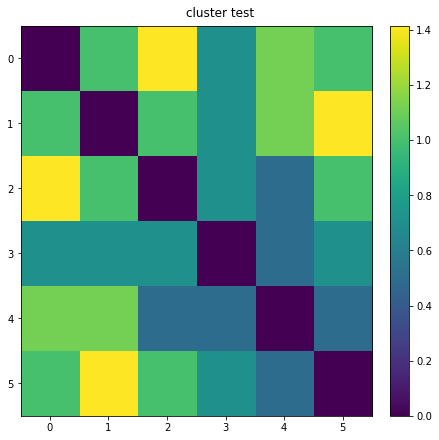

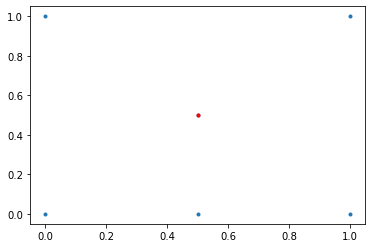

In [47]:
from sklearn.metrics import pairwise_distances

x = np.array([
    [0, 1],
    [1, 1],
    [1, 0],
    [0.5, 0.5],
    [0.5, 0],
    [0, 0]
])

d_mat_test = pairwise_distances(x)
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('cluster test')
cax = ax.matshow(d_mat_test, aspect="auto")
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)
fig = plt.figure()

lower_tril = np.tril(d_mat_test, k=-1).flatten()
lower_tril = lower_tril[lower_tril != 0]
print(lower_tril)
clusters = ClusterData(lower_tril, nPts=len(x),
                       isDistData=True, distThresh=1.0, reordering=True)
print(clusters)

centroid = clusters[0][0]
plt.plot(x.T[0], x.T[1], '.')
plt.plot(x[centroid].T[0], x[centroid].T[1], '.', color='red')
plt.show()


Number of clusters: 2 (from 100 points)


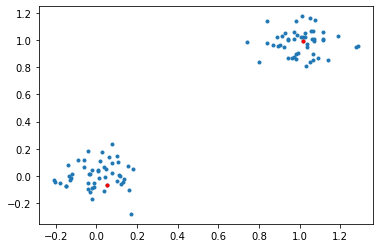

In [82]:
mean1 = [0, 0]
cov1 = [[0.01, 0], [0, 0.01]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 50).T

mean2 = [1, 1]
cov2 = [[0.01, 0], [0, 0.01]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 50).T

x = np.hstack([x1, x2])
y = np.hstack([y1, y2])
z = np.array([x, y]).T

dmat_z = pairwise_distances(z)
lower_tril = np.tril(dmat_z, k=-1).flatten()
lower_tril = lower_tril[lower_tril != 0]
clusters = ClusterData(lower_tril, nPts=len(z),
                       isDistData=True, distThresh=0.5, reordering=True)  # VERY SENSITIVE TO DISTANCE THRESHOLD
print('Number of clusters: {} (from {} points)'.format(
    len(clusters), len(z)))

cluster_inds = [list(cluster) for cluster in clusters]
centroid_x = []
centroid_y = []

for cluster in cluster_inds:
    dmat = pairwise_distances(z[cluster])
    centroid_ind = np.argmin(np.amax(dmat, axis=1))
    centroid_x.append(x[cluster[centroid_ind]])
    centroid_y.append(y[cluster[centroid_ind]])


# centroids = [cluster[0] for cluster in clusters]
# centroid_x = [ x[centroid] for centroid in centroids]
# centroid_y = [y[centroid] for centroid in centroids]
plt.plot(x, y, '.')
plt.plot(centroid_x, centroid_y, '.', color='red')
plt.show()


# MAC-1

In [2]:
def gen_dmat(fps):
    dmat = np.empty((len(fps), len(fps)))
    for i in range(len(fps)):
        dmat[i] = np.ones_like(
            len(fps)) - np.array(DataStructs.BulkTanimotoSimilarity(fps[i], fps))
    return dmat

df_clustered = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mac1_taut_clustered.csv')
df_clustered['mol'] = df_clustered['nonchiral'].apply(Chem.MolFromSmiles)
df_clustered['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in tqdm(df_clustered["smiles"])]  # pharmacophore fingerprint

clusters = df_clustered.groupby('cluster')
cluster_inds = [list(cluster) for cluster in clusters]

centroid_smiles = []
membership_list = []
for cluster, df_tmp in tqdm(clusters):
    df_tmp = df_tmp.reset_index()
    membership_list.append(len(df_tmp))
    dmat = gen_dmat(df_tmp['fps'].values)
    centroid_ind = np.argmin(np.amax(dmat, axis=1))
    centroid_smiles.append(df_tmp.iloc[centroid_ind]['smiles'])

centroid_df = df_clustered[df_clustered['smiles'].isin(centroid_smiles)]
# sort values based on centroid_smiles
centroid_df['sort_cat'] = pd.Categorical(
    centroid_df['smiles'], categories=centroid_smiles, ordered=True)
centroid_df.sort_values('sort_cat', inplace=True)
centroid_df.reset_index(inplace=True)
centroid_df['membership'] = membership_list
centroid_picks = centroid_df.iloc[:80]
pd.set_option('max_colwidth', -1)
pd.set_option('max_rows', None)
display(HTML(centroid_picks[['nonchiral']].to_html(index=False)))


100%|██████████| 22358/22358 [00:15<00:00, 1481.05it/s]
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

nonchiral
O=C(c1ccnc2[nH]c(O)nc12)N1CCCCCC1
O=C(c1cnc2[nH]c(=O)nc(O)c2c1)N1CCCCCC1
O=c1nc(O)c2cc(S(=O)(=O)N3CCCCCC3)cnc2[nH]1
CCC(CNC(=O)CCC1CCCCC1)Nc1ncnc2[nH]cnc12
CCCC(CCC)=NNc1nc(=O)c2cnn(C)c2[nH]1
Cc1cc(C(=O)N2CCCC2)nc2[nH]c(O)nc(=O)c12
CC1CCN(C(=O)c2cnn3c2[nH]c(=O)c2ccccc23)CC1
CCC(=O)NN=c1[nH]c(=O)c2cnn(C)c2[nH]1
CCC(CC)NS(=O)(=O)c1cnc2[nH]c(=O)[nH]c(=O)c2c1
CCCNS(=O)(=O)c1cnc2[nH]c(=O)[nH]c(=O)c2c1
